In [2]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Mask2FormerForUniversalSegmentation
import torch.nn as nn

from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [3]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_22296\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_22296\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [ ]:
def compute_mean_std(image_dir, selected_bands):
    images = sorted(os.listdir(image_dir))

    mean = np.zeros(len(selected_bands))
    std = np.zeros(len(selected_bands))
    pixel_count = 0

    for img_name in tqdm(images):
        img_path = os.path.join(image_dir, img_name)

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[selected_bands]

        for c in range(image.shape[0]):
            band = image[c]
            mean[c] += band.sum()
            std[c] += (band ** 2).sum()

        pixel_count += band.size

    mean /= pixel_count
    std = np.sqrt(std / pixel_count - mean ** 2)

    return mean, std


selected_bands = [0, 1, 4, 5, 6, 11] 
mean, std = compute_mean_std(image_dir, selected_bands)

print("Mean:", mean)
print("Std:", std)

  0%|          | 0/306 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
100%|██████████| 306/306 [00:02<00:00, 139.32it/s]

Mean: [ 396.46767291  494.62102853 2090.11099861 1964.05057042 1351.2739555
    9.75332642]
Std: [ 270.0665892   325.97919201 1055.9844636  1191.42213781  961.76249264
   27.75830653]


In [ ]:
class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, mean, std):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(
            self.label_dir,
            os.path.splitext(img_name)[0] + ".png"
        )

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[self.selected_bands]

        for c in range(image.shape[0]):
            image[c] = (image[c] - self.mean[c]) / (self.std[c] + 1e-8)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.int64)

        return torch.tensor(image, dtype=torch.float32), \
               torch.tensor(mask, dtype=torch.long)

In [11]:
dataset = WaterDataset(image_dir=image_dir, label_dir=label_dir , selected_bands = selected_bands , mean = mean , std = std )

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size  

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=generator
)

# DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False
)

### DeepLab

In [12]:
num_classes = 2 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet50(pretrained=True)

old_conv = model.backbone.conv1

new_conv = nn.Conv2d(
    6,
    old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)

# Copy pretrained weights for first 3 channels
new_conv.weight.data[:, :3] = old_conv.weight.data

# Initialize remaining 3 channels with mean of pretrained weights
new_conv.weight.data[:, 3:] = old_conv.weight.data.mean(dim=1, keepdim=True)

model.backbone.conv1 = new_conv

model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

model = model.to(device)

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
def compute_metrics(preds, masks):
    preds = torch.argmax(preds, dim=1)

    preds = preds.cpu().numpy().flatten()
    masks = masks.cpu().numpy().flatten()

    tp = np.sum((preds == 1) & (masks == 1))
    fp = np.sum((preds == 1) & (masks == 0))
    fn = np.sum((preds == 0) & (masks == 1))

    precision = tp / (tp + fp + 1e-8)
    recall = tp / (tp + fn + 1e-8)
    iou = tp / (tp + fp + fn + 1e-8)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-8)
    f1 = dice

    return precision, recall, iou, dice, f1

def dice_loss(pred, target):
    pred = F.softmax(pred, dim=1)
    pred = pred[:,1,:,:]
    target = target.float()

    intersection = (pred * target).sum()
    return 1 - (2. * intersection + 1) / (pred.sum() + target.sum() + 1)


In [ ]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7]).to(device))

optimizer = optim.Adam(
    model.parameters(),
    lr=2e-5,
    weight_decay=2e-5
)

num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # ================= TRAIN =================
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)["out"]

        ce = criterion(outputs, masks)
        d_loss = dice_loss(outputs, masks)

        loss = ce + d_loss  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0
    val_iou = 0
    val_dice_metric = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)["out"]

            ce = criterion(outputs, masks)
            d_loss = dice_loss(outputs, masks)

            loss = ce + d_loss
            val_loss += loss.item()

            _, _, iou, dice, _ = compute_metrics(outputs, masks)
            val_iou += iou
            val_dice_metric += dice

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice_metric /= len(val_loader)

    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")
    print(f"Val Dice:   {val_dice_metric:.4f}")

  0%|          | 0/17 [00:00<?, ?it/s]c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)
100%|██████████| 17/17 [00:07<00:00,  2.28it/s]



Epoch [1/50]
Train Loss: 1.2512
Val Loss:   1.2051
Val IoU:    0.3325
Val Dice:   0.4985


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [2/50]
Train Loss: 1.0187
Val Loss:   1.1116
Val IoU:    0.3782
Val Dice:   0.5483


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [3/50]
Train Loss: 0.8668
Val Loss:   1.0376
Val IoU:    0.4196
Val Dice:   0.5909


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]



Epoch [4/50]
Train Loss: 0.7948
Val Loss:   0.9360
Val IoU:    0.4716
Val Dice:   0.6403


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]



Epoch [5/50]
Train Loss: 0.7156
Val Loss:   0.8555
Val IoU:    0.5159
Val Dice:   0.6805


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [6/50]
Train Loss: 0.6571
Val Loss:   0.8040
Val IoU:    0.5426
Val Dice:   0.7034


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [7/50]
Train Loss: 0.6525
Val Loss:   0.7707
Val IoU:    0.5614
Val Dice:   0.7190


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [8/50]
Train Loss: 0.6698
Val Loss:   0.7629
Val IoU:    0.5536
Val Dice:   0.7122


100%|██████████| 17/17 [00:05<00:00,  3.28it/s]



Epoch [9/50]
Train Loss: 0.5814
Val Loss:   0.7256
Val IoU:    0.5907
Val Dice:   0.7426


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [10/50]
Train Loss: 0.5494
Val Loss:   0.7086
Val IoU:    0.5887
Val Dice:   0.7411


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [11/50]
Train Loss: 0.6309
Val Loss:   0.6854
Val IoU:    0.6000
Val Dice:   0.7499


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [12/50]
Train Loss: 0.5146
Val Loss:   0.6756
Val IoU:    0.6012
Val Dice:   0.7508


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]



Epoch [13/50]
Train Loss: 0.5261
Val Loss:   0.6563
Val IoU:    0.6126
Val Dice:   0.7596


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]



Epoch [14/50]
Train Loss: 0.4985
Val Loss:   0.6548
Val IoU:    0.6112
Val Dice:   0.7584


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]



Epoch [15/50]
Train Loss: 0.4861
Val Loss:   0.6299
Val IoU:    0.6228
Val Dice:   0.7674


100%|██████████| 17/17 [00:05<00:00,  3.18it/s]



Epoch [16/50]
Train Loss: 0.4638
Val Loss:   0.6099
Val IoU:    0.6312
Val Dice:   0.7737


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]



Epoch [17/50]
Train Loss: 0.4988
Val Loss:   0.6008
Val IoU:    0.6281
Val Dice:   0.7713


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]



Epoch [18/50]
Train Loss: 0.4594
Val Loss:   0.6035
Val IoU:    0.6352
Val Dice:   0.7768


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]



Epoch [19/50]
Train Loss: 0.4604
Val Loss:   0.5929
Val IoU:    0.6382
Val Dice:   0.7790


100%|██████████| 17/17 [00:05<00:00,  3.31it/s]



Epoch [20/50]
Train Loss: 0.4137
Val Loss:   0.5745
Val IoU:    0.6468
Val Dice:   0.7854


100%|██████████| 17/17 [00:05<00:00,  3.29it/s]



Epoch [21/50]
Train Loss: 0.4306
Val Loss:   0.5699
Val IoU:    0.6521
Val Dice:   0.7893


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [22/50]
Train Loss: 0.4437
Val Loss:   0.5710
Val IoU:    0.6461
Val Dice:   0.7849


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [23/50]
Train Loss: 0.4084
Val Loss:   0.5688
Val IoU:    0.6511
Val Dice:   0.7886


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]



Epoch [24/50]
Train Loss: 0.4179
Val Loss:   0.5624
Val IoU:    0.6602
Val Dice:   0.7951


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]



Epoch [25/50]
Train Loss: 0.4340
Val Loss:   0.5487
Val IoU:    0.6552
Val Dice:   0.7916


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [26/50]
Train Loss: 0.4792
Val Loss:   0.5480
Val IoU:    0.6590
Val Dice:   0.7942


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [27/50]
Train Loss: 0.4159
Val Loss:   0.5555
Val IoU:    0.6522
Val Dice:   0.7893


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [28/50]
Train Loss: 0.3851
Val Loss:   0.5459
Val IoU:    0.6643
Val Dice:   0.7980


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [29/50]
Train Loss: 0.3741
Val Loss:   0.5381
Val IoU:    0.6661
Val Dice:   0.7995


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [30/50]
Train Loss: 0.3687
Val Loss:   0.5369
Val IoU:    0.6699
Val Dice:   0.8022


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]



Epoch [31/50]
Train Loss: 0.3922
Val Loss:   0.5281
Val IoU:    0.6639
Val Dice:   0.7977


100%|██████████| 17/17 [00:05<00:00,  3.00it/s]



Epoch [32/50]
Train Loss: 0.4437
Val Loss:   0.5288
Val IoU:    0.6668
Val Dice:   0.7999


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]



Epoch [33/50]
Train Loss: 0.3517
Val Loss:   0.5311
Val IoU:    0.6731
Val Dice:   0.8044


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [34/50]
Train Loss: 0.3837
Val Loss:   0.5434
Val IoU:    0.6657
Val Dice:   0.7992


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [35/50]
Train Loss: 0.3692
Val Loss:   0.5263
Val IoU:    0.6761
Val Dice:   0.8066


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [36/50]
Train Loss: 0.3763
Val Loss:   0.5157
Val IoU:    0.6680
Val Dice:   0.8008


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [37/50]
Train Loss: 0.3708
Val Loss:   0.5201
Val IoU:    0.6753
Val Dice:   0.8060


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [38/50]
Train Loss: 0.3529
Val Loss:   0.5126
Val IoU:    0.6721
Val Dice:   0.8037


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [39/50]
Train Loss: 0.3545
Val Loss:   0.5254
Val IoU:    0.6808
Val Dice:   0.8099


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [40/50]
Train Loss: 0.4661
Val Loss:   0.5510
Val IoU:    0.6641
Val Dice:   0.7980


100%|██████████| 17/17 [00:05<00:00,  3.24it/s]



Epoch [41/50]
Train Loss: 0.3561
Val Loss:   0.5326
Val IoU:    0.6573
Val Dice:   0.7932


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]



Epoch [42/50]
Train Loss: 0.3362
Val Loss:   0.5085
Val IoU:    0.6833
Val Dice:   0.8117


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [43/50]
Train Loss: 0.4471
Val Loss:   0.4825
Val IoU:    0.6937
Val Dice:   0.8190


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [44/50]
Train Loss: 0.3513
Val Loss:   0.4943
Val IoU:    0.6883
Val Dice:   0.8154


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [45/50]
Train Loss: 0.3177
Val Loss:   0.4929
Val IoU:    0.6919
Val Dice:   0.8177


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]



Epoch [46/50]
Train Loss: 0.3116
Val Loss:   0.4774
Val IoU:    0.6980
Val Dice:   0.8220


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [47/50]
Train Loss: 0.3294
Val Loss:   0.4814
Val IoU:    0.6985
Val Dice:   0.8223


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [48/50]
Train Loss: 0.3350
Val Loss:   0.4682
Val IoU:    0.7021
Val Dice:   0.8249


100%|██████████| 17/17 [00:05<00:00,  3.26it/s]



Epoch [49/50]
Train Loss: 0.3564
Val Loss:   0.4851
Val IoU:    0.6969
Val Dice:   0.8213


100%|██████████| 17/17 [00:05<00:00,  3.27it/s]



Epoch [50/50]
Train Loss: 0.3334
Val Loss:   0.4693
Val IoU:    0.7064
Val Dice:   0.8279


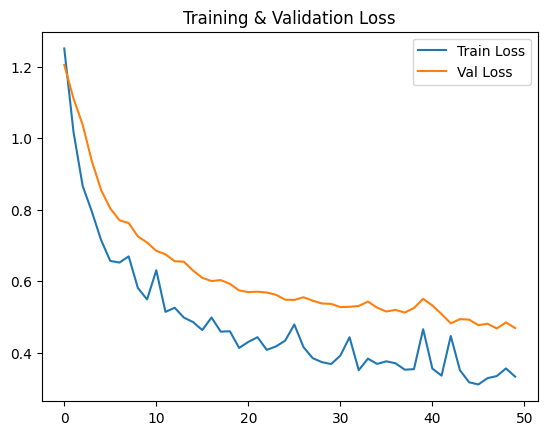

In [15]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()